In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F


In [2]:
transform = transforms.ToTensor()

train_val_dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)

In [3]:
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))

In [4]:
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])

In [5]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
print("Train set contains %d images in %d batches" % (len(trainloader.dataset),len(trainloader)))
print("Validation set contains %d images in %d batches" % (len(valloader.dataset),len(valloader)))
print("Test set contains %d images in %d batches" % (len(testloader.dataset),len(testloader)))

Train set contains 48000 images in 3000 batches
Validation set contains 12000 images in 750 batches
Test set contains 10000 images in 625 batches


In [7]:
cuda = torch.cuda.is_available()
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

# Classifier

In [8]:
class Classifier(nn.Module):
    """A Neural Network with a hidden layer"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(784, 500)
        self.layer2 = nn.Linear(500, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.layer1(x)
        output = self.relu(output)
        output = self.layer2(output)
        return output
classifier = Classifier()
if cuda:
    classifier = classifier.cuda()
classifier

Classifier(
  (layer1): Linear(in_features=784, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
)

In [9]:
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [10]:
epochs = 10
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        #images = images.view(images.size()[0], -1)
        images = images.reshape(-1,28*28)
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        output = classifier(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  
    classifier.eval()
    total_correct = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            #images = images.view(images.size()[0], -1)
            images = images.reshape(-1,28*28)
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            output_acc = classifier(images)
            loss = criterion(output_acc,labels)
            val_loss += loss.item()/images.shape[0]
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, runningloss, val_loss, accuracy))

Epoch: 1/10 	 Training Loss: 100.79147772165015, Validation loss: 19.43626855686307, Validation Accuracy: 0.8476666666666667
Epoch: 2/10 	 Training Loss: 74.63729165121913, Validation loss: 17.411425347439945, Validation Accuracy: 0.8644166666666667
Epoch: 3/10 	 Training Loss: 67.22837484721094, Validation loss: 17.021589705720544, Validation Accuracy: 0.8699166666666667
Epoch: 4/10 	 Training Loss: 63.03469645790756, Validation loss: 17.47584354598075, Validation Accuracy: 0.86125
Epoch: 5/10 	 Training Loss: 59.09568320401013, Validation loss: 16.151463934220374, Validation Accuracy: 0.876
Epoch: 6/10 	 Training Loss: 56.607101486995816, Validation loss: 16.5913220141083, Validation Accuracy: 0.8650833333333333
Epoch: 7/10 	 Training Loss: 53.77162315649912, Validation loss: 16.819740558043122, Validation Accuracy: 0.8720833333333333
Epoch: 8/10 	 Training Loss: 51.63263403438032, Validation loss: 15.917824039235711, Validation Accuracy: 0.8791666666666667
Epoch: 9/10 	 Training Los

In [11]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    images = images.reshape(-1,28*28)
    outputs = classifier(images.cuda())
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 82.198523 %
Accuracy of trouser : 96.842105 %
Accuracy of pullover : 86.974110 %
Accuracy of dress : 92.161929 %
Accuracy of  coat : 69.620253 %
Accuracy of sandal : 94.955965 %
Accuracy of shirt : 73.099415 %
Accuracy of sneaker : 96.877710 %
Accuracy of   bag : 95.546559 %
Accuracy of ankle boot : 94.448980 %


# Autoencoder

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 100), 
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.ReLU()
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
auto = AutoEncoder()
if cuda:
    auto = auto.cuda()
auto

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
)

In [12]:
optimizer = optim.SGD(auto.parameters(), lr=0.5, momentum=0.9)
criterion = nn.MSELoss()

In [13]:
epochs = 10
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images = images.view(images.size()[0], -1)
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = auto(images)
        loss = criterion(output, images.view(images.size()[0], -1))
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

Epoch: 1/10 	 Mean Square Error Loss: 7.555399553501047
Epoch: 2/10 	 Mean Square Error Loss: 4.770978554268368
Epoch: 3/10 	 Mean Square Error Loss: 4.009717193606775
Epoch: 4/10 	 Mean Square Error Loss: 3.5881215280969627
Epoch: 5/10 	 Mean Square Error Loss: 3.435657706228085
Epoch: 6/10 	 Mean Square Error Loss: 3.305909551680088
Epoch: 7/10 	 Mean Square Error Loss: 3.120934632141143
Epoch: 8/10 	 Mean Square Error Loss: 3.039357805333566
Epoch: 9/10 	 Mean Square Error Loss: 2.9837221670895815
Epoch: 10/10 	 Mean Square Error Loss: 2.876041799376253


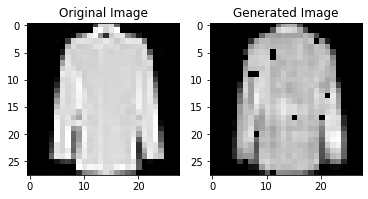

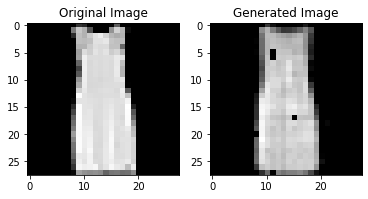

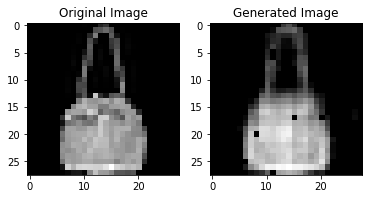

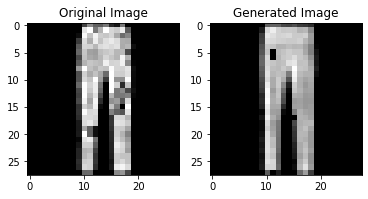

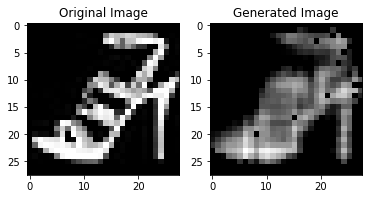

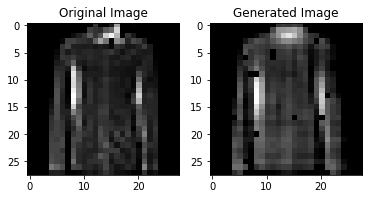

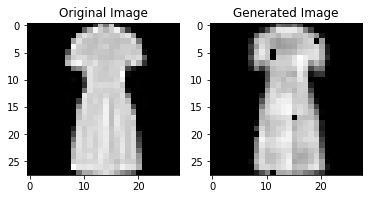

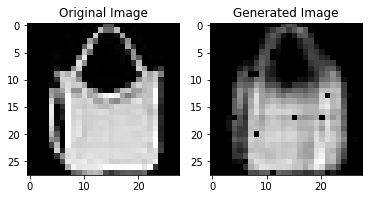

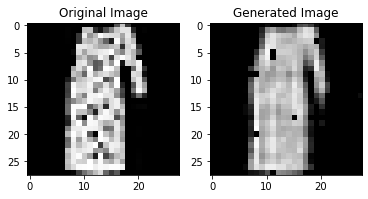

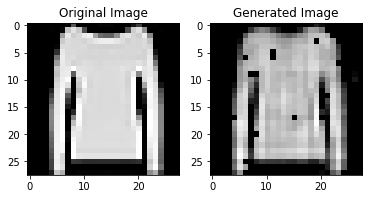

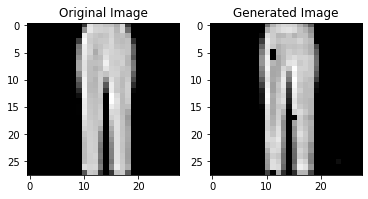

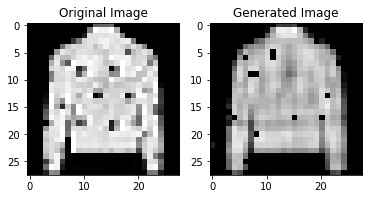

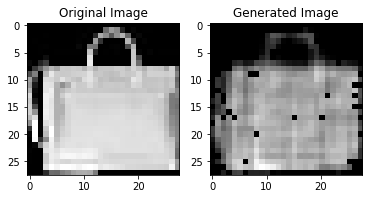

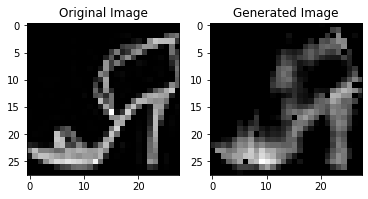

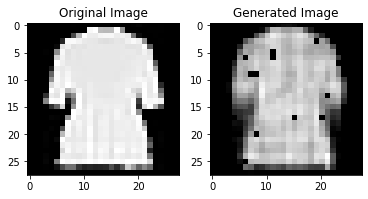

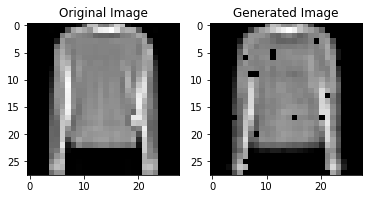

In [14]:
test_images, labels = next(iter(valloader))
test_images = test_images.view(test_images.size()[0], -1)
if cuda:
    test_images = test_images.view(test_images.size()[0], -1).cuda()
test_output = auto(test_images)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Autoencoder + Classifier Combined (without decoder part in model - one loss)

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 100), 
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.ReLU()
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
net1 = AutoEncoder()
if cuda:
    net1 = net1.cuda()
net1

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
)

In [16]:
new_classif = nn.Sequential(*list(net1.children())[:-1])
net1 = new_classif
net1.add_module('classifier', nn.Sequential(nn.Linear(100, 10), nn.LogSoftmax(dim=1)))
if cuda:
    net1 = net1.cuda()
net1

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.01, momentum=0.9)

In [18]:
epochs = 10
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images = images.view(images.size()[0], -1)
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        output = net1(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  
    net1.eval()
    total_correct = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(images.size()[0], -1)
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            output_acc = net1(images)
            loss = criterion(output_acc,labels)
            val_loss += loss.item()/images.shape[0]
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, runningloss, val_loss, accuracy))

Epoch: 1/10 	 Training Loss: 108.51315992511809, Validation loss: 22.261246223933995, Validation Accuracy: 0.8145
Epoch: 2/10 	 Training Loss: 77.15386546275113, Validation loss: 17.991587425698526, Validation Accuracy: 0.8563333333333333
Epoch: 3/10 	 Training Loss: 69.85221964569064, Validation loss: 20.017977447714657, Validation Accuracy: 0.8476666666666667
Epoch: 4/10 	 Training Loss: 64.59446097153705, Validation loss: 16.12170576682547, Validation Accuracy: 0.8719166666666667
Epoch: 5/10 	 Training Loss: 61.4333236037055, Validation loss: 16.294118214631453, Validation Accuracy: 0.8765833333333334
Epoch: 6/10 	 Training Loss: 58.62448868394131, Validation loss: 15.881386222725268, Validation Accuracy: 0.871
Epoch: 7/10 	 Training Loss: 56.22629227815196, Validation loss: 16.41267429923755, Validation Accuracy: 0.86775
Epoch: 8/10 	 Training Loss: 54.20024254832242, Validation loss: 16.4918904529477, Validation Accuracy: 0.8729166666666667
Epoch: 9/10 	 Training Loss: 52.19050732

In [19]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    outputs = net1(images.view(-1, 28*28).cuda())
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 89.486964 %
Accuracy of trouser : 98.214286 %
Accuracy of pullover : 77.882960 %
Accuracy of dress : 92.892562 %
Accuracy of  coat : 70.975813 %
Accuracy of sandal : 94.037067 %
Accuracy of shirt : 63.983402 %
Accuracy of sneaker : 91.891892 %
Accuracy of   bag : 97.970779 %
Accuracy of ankle boot : 97.886729 %


# Autoencoder + Classifier Combined (without decoder part in model - one loss, classifier defined in model)

In [20]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(100, 10), 
            nn.LogSoftmax(dim=1)
        )
  
    def forward(self, x):
        x = self.encoder(x)
        label = self.classifier(x)
        return label
net2 = AutoEncoder()
if cuda:
    net2 = net2.cuda()
net2

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)

In [22]:
epochs = 10
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images = images.view(images.size()[0], -1)
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        output = net2(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  
    net2.eval()
    total_correct = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(images.size()[0], -1)
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            output_acc = net2(images)
            loss = criterion(output_acc,labels)
            val_loss += loss.item()/images.shape[0]
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, runningloss, val_loss, accuracy))

Epoch: 1/10 	 Training Loss: 108.05478785713785, Validation loss: 20.26542828581296, Validation Accuracy: 0.836
Epoch: 2/10 	 Training Loss: 76.84054274880327, Validation loss: 17.667169441701844, Validation Accuracy: 0.86175
Epoch: 3/10 	 Training Loss: 69.6809823346266, Validation loss: 19.356066776672378, Validation Accuracy: 0.8526666666666667
Epoch: 4/10 	 Training Loss: 64.1916458477499, Validation loss: 17.36406448262278, Validation Accuracy: 0.8588333333333333
Epoch: 5/10 	 Training Loss: 61.11773821274983, Validation loss: 16.557662840525154, Validation Accuracy: 0.8713333333333333
Epoch: 6/10 	 Training Loss: 57.77464178254013, Validation loss: 15.606074377370533, Validation Accuracy: 0.87825
Epoch: 7/10 	 Training Loss: 56.11179480684223, Validation loss: 15.654140198254026, Validation Accuracy: 0.8729166666666667
Epoch: 8/10 	 Training Loss: 53.6938357589388, Validation loss: 15.02202010541805, Validation Accuracy: 0.8800833333333333
Epoch: 9/10 	 Training Loss: 51.92743422

In [23]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    outputs = net2(images.view(-1, 28*28).cuda())
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 93.187553 %
Accuracy of trouser : 98.538961 %
Accuracy of pullover : 83.046472 %
Accuracy of dress : 89.834711 %
Accuracy of  coat : 72.727273 %
Accuracy of sandal : 97.743755 %
Accuracy of shirt : 54.688797 %
Accuracy of sneaker : 92.938099 %
Accuracy of   bag : 97.077922 %
Accuracy of ankle boot : 96.111581 %


# Autoencoder + Classifier Combined Model (two losses)

In [24]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        predicted = self.classifier(encoded)
        return decoded, predicted
net3 = Mixed()
net3 = net3.cuda()
net3

Mixed(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)

In [25]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)


In [26]:
epochs = 10
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, predicted = net3(images)
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted, labels)
        loss = loss1+loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  

    net3.eval()
    total_correct = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            decoded, output_acc = net3(images)
            test_loss1 = criterion1(decoded,images)
            test_loss2 = criterion2(output_acc, labels)
            test_loss = test_loss1+test_loss2
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
            val_loss += test_loss.item()/images.shape[0]
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, runningloss, val_loss, accuracy))

Epoch: 1/10 	 Training Loss: 127.04165339749306, Validation loss: 23.38714529853314, Validation Accuracy: 0.8489166666666667
Epoch: 2/10 	 Training Loss: 92.22055001743138, Validation loss: 21.77299905056134, Validation Accuracy: 0.8486666666666667
Epoch: 3/10 	 Training Loss: 82.77665626397356, Validation loss: 20.003795144613832, Validation Accuracy: 0.8663333333333333
Epoch: 4/10 	 Training Loss: 76.58327396470122, Validation loss: 19.50889289472252, Validation Accuracy: 0.8673333333333333
Epoch: 5/10 	 Training Loss: 71.34906882699579, Validation loss: 19.691576410084963, Validation Accuracy: 0.86425
Epoch: 6/10 	 Training Loss: 68.23518454935402, Validation loss: 18.811960596824065, Validation Accuracy: 0.8704166666666666
Epoch: 7/10 	 Training Loss: 65.71804798441008, Validation loss: 18.162964144255966, Validation Accuracy: 0.8726666666666667
Epoch: 8/10 	 Training Loss: 62.93834374565631, Validation loss: 17.951297789812088, Validation Accuracy: 0.8734166666666666
Epoch: 9/10 	

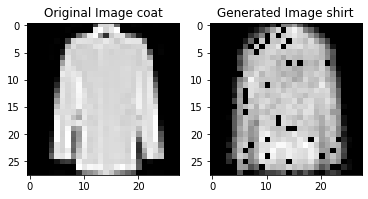

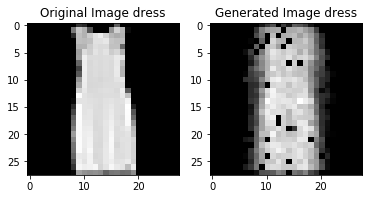

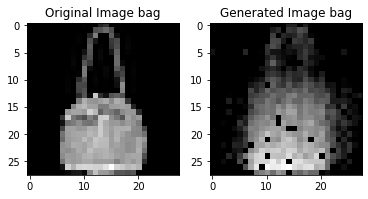

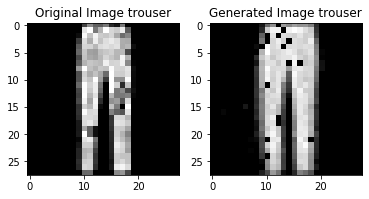

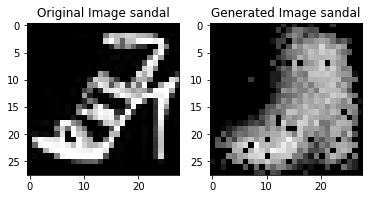

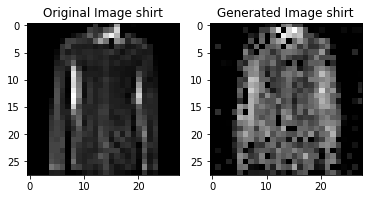

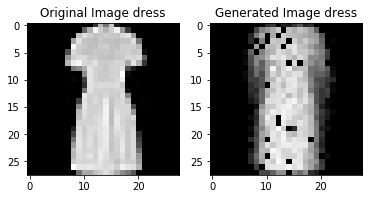

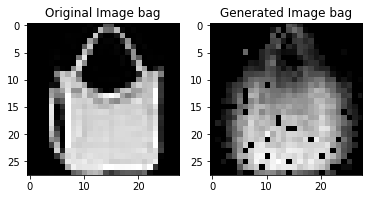

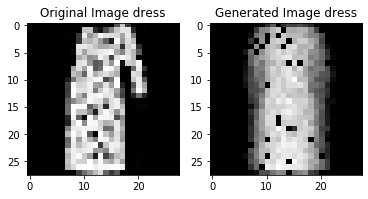

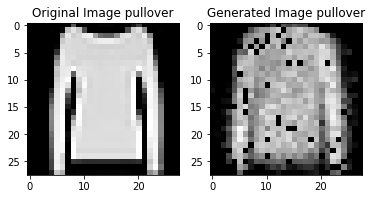

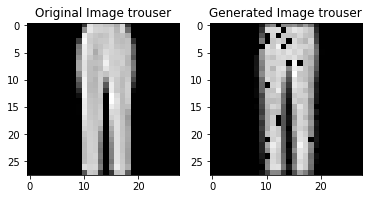

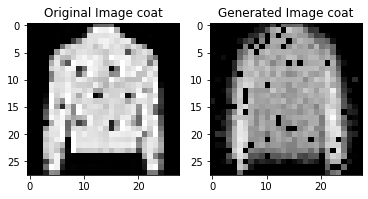

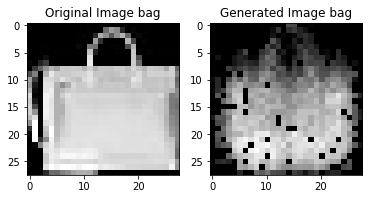

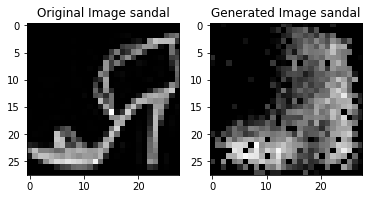

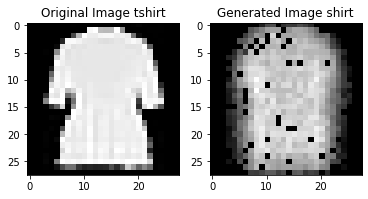

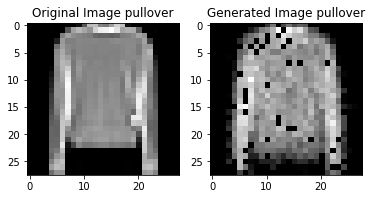

In [27]:
test_images, labels = next(iter(valloader))

test_images = test_images.view(test_images.size()[0], -1).cuda()
test_output, predicted = net3(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    #print("Ground truth", classes[labels[i]])
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    #print("Predicted", classes[predicted_label[i]])
    plt.show()

In [28]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    decoded, outputs = net3(Variable(images.view(-1, 28*28).cuda()))
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 79.983179 %
Accuracy of trouser : 98.051948 %
Accuracy of pullover : 87.349398 %
Accuracy of dress : 90.826446 %
Accuracy of  coat : 72.894078 %
Accuracy of sandal : 94.681708 %
Accuracy of shirt : 65.145228 %
Accuracy of sneaker : 95.902354 %
Accuracy of   bag : 97.727273 %
Accuracy of ankle boot : 95.266272 %


In [29]:
total_correct = 0
total_loss = 0
with torch.no_grad():
    net3.eval()
    for images, labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, output_acc = net3(images)
        test_loss1 = criterion1(decoded,images)
        test_loss2 = criterion2(output_acc, labels)
        test_loss = test_loss1+test_loss2
        _, pred = torch.max(output_acc, 1)
        total_correct += torch.sum(pred==labels).item()
        total_loss += test_loss.item()/images.shape[0]
    accuracy = total_correct / len(testloader.dataset)
print("Test loss: {}, accuracy: {}".format(total_loss,accuracy))

Test loss: 15.561899434775114, accuracy: 0.8727


# Cells currently not in use

In [ ]:
#NOT IN USE
correct = 0
total = 0
with torch.no_grad():
    for images,labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, output_acc = net(images)
        _, predicted = torch.max(output_acc, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network: %.3f %%' % (
    100 * correct / total))

In [ ]:
#NOT CURRENTLY IN USE - TRAINING THE AUTOENCODER BY ITSELF
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, images.view(images.size()[0], -1))
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

In [ ]:
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        output = net(images)
        #print(images.shape) #16x784
        #print(labels.shape) #16
        #print(output.shape) #16x10
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  

    net.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            output_acc = net(images)
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        accuracy = total_correct / len(testloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Test Accuracy: {}'.format(epoch, epochs, runningloss, accuracy))

